In [21]:
import pickle
import seaborn as sns
import pandas as pd
from Evaluation import generate_test_subjects
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm_notebook as tqdm
import scipy
from scipy.ndimage import zoom
from fsl.data.image import Image
from fsl.utils.image import resample
import torchio as tio
import glob
from sklearn.model_selection import train_test_split
import argparse
import os
from Preprocess import write_data
from utils import plot_images
import pandas as pd
from skimage.metrics import structural_similarity as ssim_sklearn

In [2]:
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(len(slices), len(slices[0]))
    fig.set_size_inches(15,7.5)
    for row in range(len(slices)):
        for column in range(len(slices[0])):
            axes[row][column].imshow(slices[row][column].T, cmap="gray", origin="lower")


def plot_images(inp_np,res_np):
    slice_0 = inp_np[int(inp_np.shape[0]/2), :, :]
    slice_1 = inp_np[:, int(inp_np.shape[1]/2), :]
    slice_2 = inp_np[:, :, int(inp_np.shape[2]/2)]
    nslice_0 = res_np[int(res_np.shape[0]/2), :, :]
    nslice_1 = res_np[:, int(res_np.shape[1]/2), :]
    nslice_2 = res_np[:, :, int(res_np.shape[2]/2)]
    show_slices([[slice_0, slice_1, slice_2],
                 [nslice_0, nslice_1, nslice_2]])

In [ ]:
actual_images = os.listdir(os.path.join("IXI-T1","Actual_Images"))
target_dir = os.listdir(os.path.join("IXI-T1","Compressed_4.0x4.0x1.2_nozoom"))
pix_dims = [4,4,1.2]
for scan in tqdm(actual_images):
    fname = os.path.join("IXI-T1","Actual_Images",scan)
    img   = Image(fname)
    resample_img = resample.resampleToPixdims(img, pix_dims)
    write_data(resample_img[0],scan,resample_img[1],pix_dims,"IXI-T1")

In [ ]:
print(img.shape)

In [35]:
test_subjects = generate_test_subjects()

Set the mode based on the method of interpolation required
0 - Nearest
1 - Bilinear
3 - Bicubic

In [17]:
mode = 0

In [23]:
results = {}
modes = [0,1,3]

for mode in modes:
    ssim_list = []
    for subject in tqdm(test_subjects[1]):
        gt,comp = np.squeeze(subject.ground_truth["data"].numpy()),np.squeeze(subject.compressed["data"].numpy())
        zoom_factor = np.array(gt.shape) / np.array(comp.shape)
        zoomed = zoom(comp, zoom_factor, order=mode)
        ssim = ssim_sklearn(zoomed,gt,data_range = gt.max()-gt.min())
        ssim_list.append(ssim)
    if mode == 0:
        results['nearest'] = ssim_list
    elif mode == 1:
        results['bilinear']= ssim_list
    else:
        results["bicubic"] = ssim_list

with open("legacy_methods.pickle",'wb') as handler:
    pickle.dump(results,handler)

d:\program files\python37\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


<AxesSubplot:>

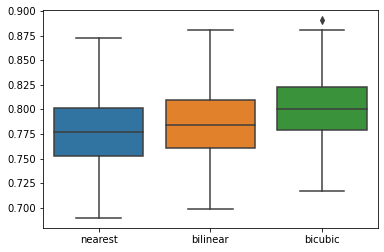

In [24]:
with open("legacy_methods.pickle",'rb') as handler:
    results = pickle.load(handler)



Text(0.5, 1.0, 'Super resolution on 4x4x1.2 images')

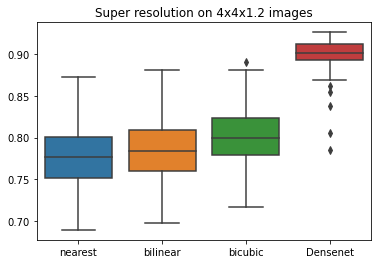

In [28]:
with open("ssims_variable_kernel.data",'rb') as handler2:
    dictionary = pickle.load(handler2)

results["Densenet"] = dictionary['Compressed_4.0x4.0x1.2']
df = pd.DataFrame.from_dict(results)
sns.boxplot(data=df).set_title("Super resolution on 4x4x1.2 images")

In [29]:
import torch
import torchio
import matplotlib.pyplot as plt
from utils import plot_images
import DenseNetModel
from pathlib import Path
from sklearn.model_selection import train_test_split
import os
import torchio as tio
from torchio.transforms import Compose,ZNormalization,RescaleIntensity
from torchio import AFFINE,DATA
import random
import pickle
import seaborn as sns
import pandas as pd

In [52]:
def write_image(slice_list,ssim):
    print("writing image.......")
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle("ssim : {}".format(ssim))
    ax[0].imshow(slice_list[0], interpolation='nearest', origin="lower", cmap="gray")
    ax[0].set_title("Original")
    ax[0].set_axis_off()
    ax[1].imshow(slice_list[1], interpolation='nearest', origin="lower", cmap="gray")
    ax[1].set_title("Bicubic")
    ax[1].set_axis_off()
    ax[2].imshow(slice_list[2], interpolation='nearest', origin="lower", cmap="gray")
    ax[2].set_title("Predicted")
    ax[2].set_axis_off()
    plt.show()

In [49]:
def test_network(sample):
    patch_size = 48,48,48
    patch_overlap = 4,4,4
    model.eval()
    grid_sampler = tio.inference.GridSampler(sample,patch_size,patch_overlap)
    patch_loader = torch.utils.data.DataLoader(grid_sampler,int(validation_batch_size/4))
    aggregator = tio.inference.GridAggregator(grid_sampler,overlap_mode="average")
    with torch.no_grad():
        for batch in tqdm(patch_loader):
            inputs = batch["compressed"][DATA].to("cuda")
            logits = model(inputs)
            location = batch[tio.LOCATION]
            aggregator.add_batch(logits,location)
    model.train()
    result = aggregator.get_output_tensor()
    original, compressed = sample.ground_truth["data"].squeeze(), sample.compressed["data"].squeeze()
    result = torch.squeeze(result)
    original,compressed,result = original.detach().cpu().numpy(),compressed.detach().cpu().numpy(),result.detach().cpu().numpy()
    ssim_val = ssim_sklearn(original,result,data_range=original.max()-original.min())
    return original,compressed,result,ssim_val

d:\program files\python37\lib\site-packages\ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


d:\program files\python37\lib\site-packages\ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



writing image.......


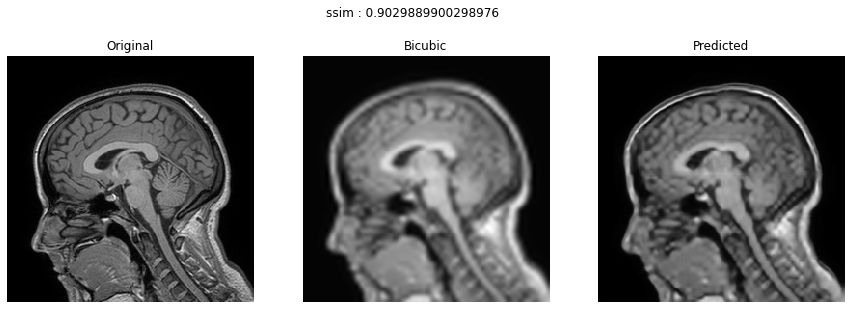


writing image.......


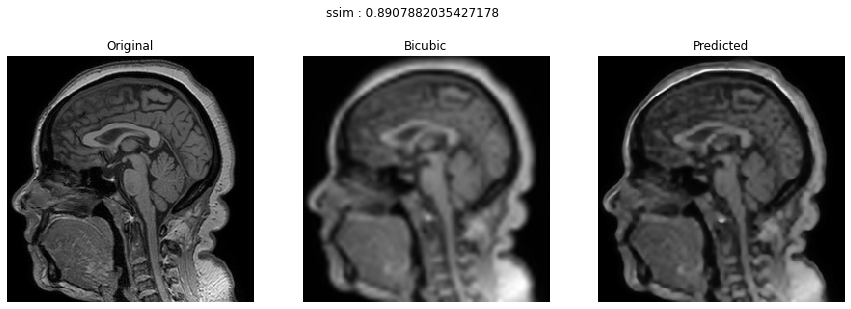


writing image.......


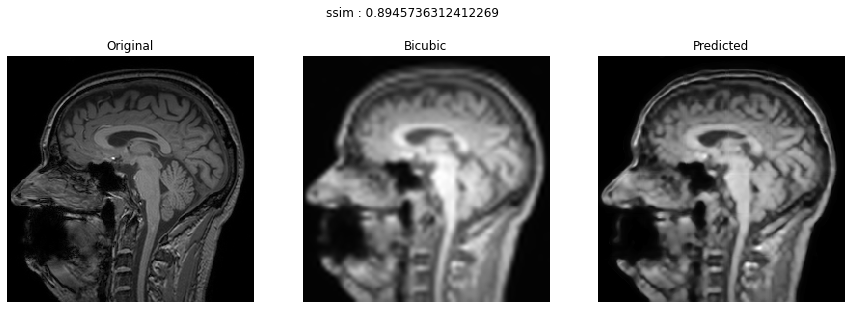


writing image.......


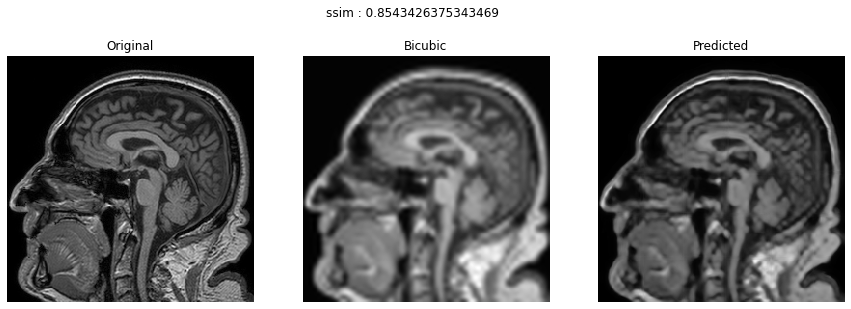


writing image.......


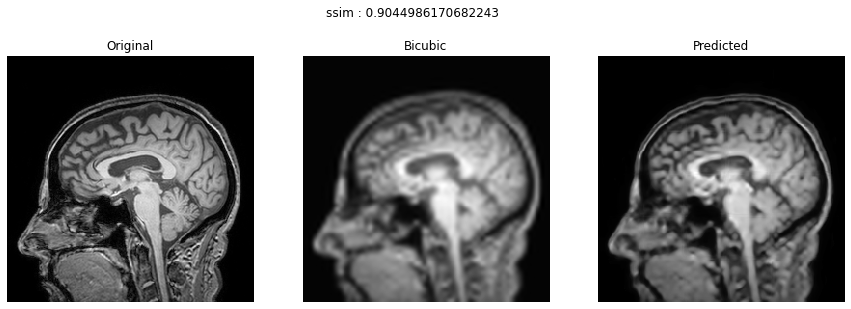

In [53]:
state_dict = torch.load("Models/DenseNet varying kernel with scale augmentation/denseNet3D_torchIO_patch_32_samples_20_ADAMOptim_50Epochs_BS12_GlorotWeights_SSIM_1511.pth")
model = DenseNetModel.DenseNet(num_init_features=4,growth_rate=6,block_config=(6,6,6)).to("cuda")
model.load_state_dict(state_dict["model_state_dict"])
validation_batch_size = 12
test_transform = Compose([RescaleIntensity((0,1))])

test_subjects = generate_test_subjects()
samples = random.sample(test_subjects[0],5)
test_dataset = tio.SubjectsDataset(samples,transform=test_transform)



for sample in test_dataset:
    original,compressed,result,ssim_val = test_network(sample)
    slice_original = (original[:, :, int(original.shape[2] / 2)])
    slice_compressed = (compressed[:, :, int(compressed.shape[2] / 2)])
    slice_result = (result[:, :, int(result.shape[2] / 2)])
    slice_list = [slice_original.T,slice_compressed.T,slice_result.T]
    write_image(slice_list,ssim_val)